# Calcium Imaging Analysis Workbook
Daniel

July 9, 2018

----

Table of Contents:

   1. How I calculated the derivates
   
   2. Load required libraries
   
   3. Implement a class that:
   
       - holds data from workbook
       
       - calculates the first derivative (`calc_derivative`)
       
       - plots the largest derivative per cell across spreadsheets (`plot_derivatives`)
   
   
   4. Save data to current working directory
 
----

## How I calculated the derivatives
This solution assumes that the underlying function $y$ is several times differentiable for all $x$ in an interval which covers the entire range of values. This is a reasonable assumption, as values (rarely) vary abruptly.

If this assumption is satisfied, then we can approximate the derivative of $y$ at each point using **finite difference approximations**.

It further simplifies matters that all points are equidistant on the $x$ axis. Let $h$ denote their constant separation. In this case $h=1$. 

If $x$ is an internal point, i.e., both $x-h$ and $x+h$ are data points, then the standard space central approximation of $y'(x)$ is
$$ y'(x) \approx \frac{y(x+h) - y(x-h)}{2h} $$
The absolute value of the error is $O(h^2)$, i.e. it is bounded by a constant multiplied with $h^2$.

If $x$ is an endpoint, e.g. the left end point, then
$$ y'(x) \approx \frac{y(x+h)-y(x)}{h},$$
was used where the error is $O(h)$. 

An alternative is a one side approximation, such as
$$ y'(x) \approx \frac{-3 y(x) + 4y(x+h) - y(x+2h)}{2h},$$
where the error is $O(h^2)$.

## Load required libraries

In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [3]:
# enter the fully qualified file path to the cleaned excel spread sheet
file_path = "2018July5_10h45min31s_sorted_ratios.xlsx"

In [19]:
# define class 'Workbook'
class Workbook(object):
    """
    class 'Workbook' holds data of (potentially multiple) Excel spread sheets and comprises 
    methods to modify/manipulate this data. Workbook does not inhibit from anything but object.
    """
    def __init__(self, path):
        """
        takes a valid file path to a .xlsx file and reads it in; also iterates over the 
        different sheets in that workbook and appends their names to a newly initialized list.
        """
        # read the excel workbook in
        self.raw_data = pd.read_excel(path, sheet_name=None)

        # append individual names to a list of sheet names
        self.sheet_names = []
        for idx, name in enumerate(self.raw_data):
            #print("number {}: {}".format(idx+1, name))
            self.sheet_names.append(name)
        if len(self.sheet_names) < 2:
            print("did not get more than one spread sheet to read; is that correct?")
            
        # create empty list to hold dataframes with derivates
        self.derivative_df_list = []
        self.derivatives_table = pd.DataFrame()
        
        # shorten input for debugging purposes
        #self.sheet_names = self.sheet_names[0:3]
        
    def calc_derivative(self):
        """
        calculates derivatives and creates a class member 'derivative_df_list' that holds all
        dataframes with the respective derivatives and that can be used for plotting.
        """        
        # iterate over spread sheets (i.e. dataframes), calculate derivatives and append
        # results the newly created list of derivate-holding dataframes
        for name in self.sheet_names:
            # create a temporary dataframe
            if name != "Sheet1":
                __df = self.raw_data[name]
                #print("created temporary {} with dim: {}".format(type(__df), __df.shape))
            else:
                print("skipped sheet: {}".format(name))
                continue
                
            # loop over columns of temporary dataframe and calculate derivates that are 
            # then copy to new dataframe and appended to a list of dataframes for further use
            rows = __df.shape[0]
            cols = __df.shape[1]
            __derivative_df = pd.DataFrame()
            
            # iterate over columns
            for i in range(cols):
                #print(i)
                __derivative_list = []
                
                # iterate over rows
                for j in range(rows):
                    if j == 0:
                        __derivative_list.append(((__df.iloc[(j+1), i]) - (__df.iloc[j, i])) / 2)
                    elif j == (rows - 1):
                        __derivative_list.append(((__df.iloc[j, i]) - (__df.iloc[(j-1), i])) / 2)
                    else:
                        __derivative_list.append(((__df.iloc[(j+1), i]) - (__df.iloc[(j-1), i])) / 2)
                    
                # for first col, create new data frame; otherwise, concatenate two list and dataframe
                if __derivative_df.empty:
                    #print("create new tmp df")
                    __derivative_df = pd.DataFrame(__derivative_list)
                else:
                    #print("append to tmp df")
                    __derivative_df = pd.concat([__derivative_df, 
                                                 pd.DataFrame(__derivative_list)], axis=1)
                    
            # append temporary data frame to a list of derivative-holding dataframes        
            #print(__derivative_df)
            self.derivative_df_list.append(__derivative_df)
            
            
    def plot_derivatives(self, spread_sheet=None):
        """
        plots derivatives (optionally, only for a certain spread sheet); 
        call only after calling 'calc_derivatives()'
        """
        # check if derivatives are already calculated
        if not self.derivative_df_list:
            print("call 'calc_derivatives()' first!")
            return
        
        # plot derivates
        for idx, _df in enumerate(self.derivative_df_list):
            # names are not save! they rely on an ordered input! try to avoid empty sheets
            # like 'Sheet1', especially if that empty sheet is not the first sheet (i.e 'idx+1')!
            print("{} max value: {},\n\t\tmean value: {}, median: {}".format(self.sheet_names[(idx+1)], 
                                                                             np.max(_df.max()), 
                                                                             np.mean(_df.max()), 
                                                                             np.median(_df.max())))
            plt.rcParams.update({'figure.max_open_warning': 0})
            _df.plot(legend=False, title=self.sheet_names[idx+1])
            
    def get_max_derivatives(self):
        """
        Doc string
        """
        # check if derivates are already calculated
        if not self.derivative_df_list:
            print("call 'calc_derivates()' first!")
            return
        
        # iterate over derivative dataframes and return their 
        # column-wise max values in a new 'long' dataframe
        #################################
        ## max_derivative ## coverslip ##
        ## 0.124          ## wt        ##
        ## 0.634          ## wt        ##
        ## ...            ## ...       ##
        #################################
        _df = pd.DataFrame()
        for idx, _tmp in enumerate(self.derivative_df_list):
            _names_list = []
            for i in range(_tmp.shape[1]):
                _names_list.append(self.sheet_names[(idx+1)])                
            _dict = {"max_derivative": _tmp.max(), "coverslip": _names_list}
            if idx == 0:
                _df = pd.DataFrame(_dict)
            else:
                _df = pd.concat([_df, pd.DataFrame(_dict)], axis=0)
            
        # write long dataframe with max derivatives to data frame
        self.derivatives_table = _df
        
    def plot_max_derivatives(self):
        """
        Doc string
        """
        # check if data frame of max derivatives is already calculated
        if self.derivatives_table.empty:
            print("call 'calc_derivates()' and 'get_max_derivatives()' first!")
            return
        
        fp = sns.factorplot(x="coverslip", y="max_derivative", data=self.derivatives_table, kind="box", 
                            size=8, aspect=1.8, saturation=0.5, width=0.7, fliersize=8, linewidth=4);
        fp.despine(top=False, right=False);
        plt.grid(b=True, which="major");
        plt.xlabel("Coverslip Labels", fontsize=20);
        plt.ylabel("Maximum Derivatives", fontsize=20);
        plt.xticks(fontsize=16, rotation=90)
        plt.yticks(fontsize=16)
        plt.title("Maximum Derivates Across Multiple Cells and Coverslips", fontsize=24);

skipped sheet: Sheet1


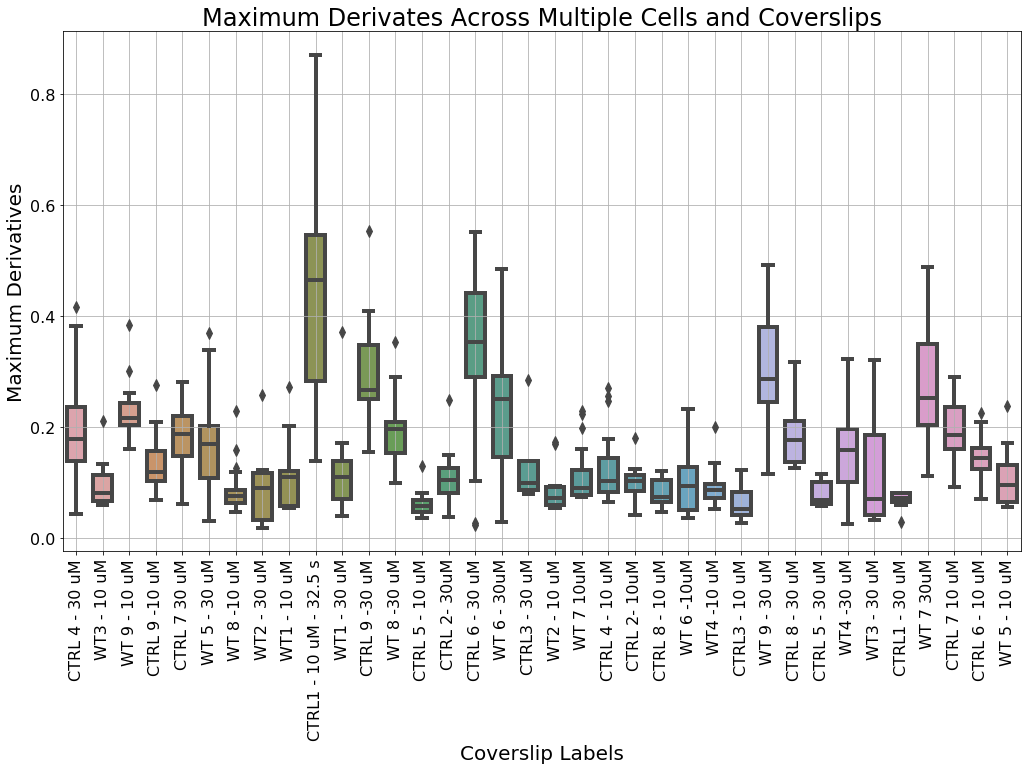

In [20]:
wb = Workbook(file_path)
wb.calc_derivative()
wb.get_max_derivatives()
wb.plot_max_derivatives()

CTRL 4 - 30 uM max value: 0.41595404858092966,
		mean value: 0.1955325381745582, median: 0.1780114651481663
WT3 - 10 uM max value: 0.20996495174710217,
		mean value: 0.09551288008864003, median: 0.08013155140201556
WT 9 - 10 uM max value: 0.38363529346788605,
		mean value: 0.22985450182655698, median: 0.2155071888182768
CTRL 9 -10 uM max value: 0.27603513987891715,
		mean value: 0.13628857340797146, median: 0.11927534690716357
CTRL 7 30 uM max value: 0.28072672275279664,
		mean value: 0.18677816451630377, median: 0.18683194836484995
WT 5 - 30 uM max value: 0.3685022506838914,
		mean value: 0.17209102382930178, median: 0.16929626922607643
WT 8 -10 uM max value: 0.228628822104731,
		mean value: 0.08686135296958968, median: 0.07453573094993776
WT2 - 30 uM max value: 0.2582258943463742,
		mean value: 0.09095171737231096, median: 0.08911099073694917
WT1 - 10 uM max value: 0.27105931811925366,
		mean value: 0.12046122269235982, median: 0.11016784827982185
CTRL1 - 10 uM - 32.5 s max value: 0.

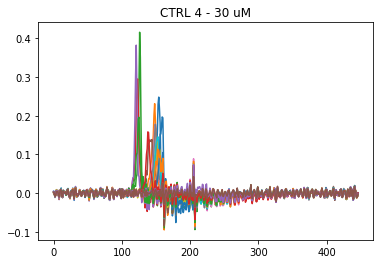

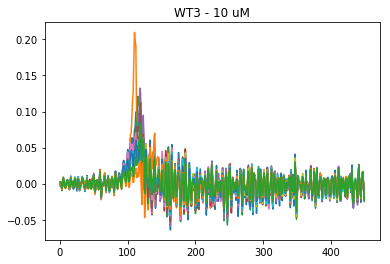

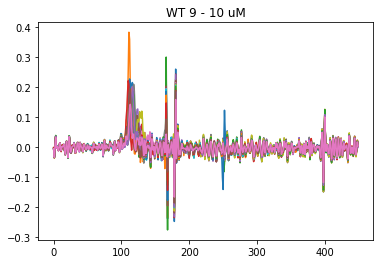

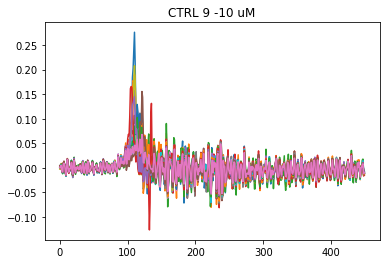

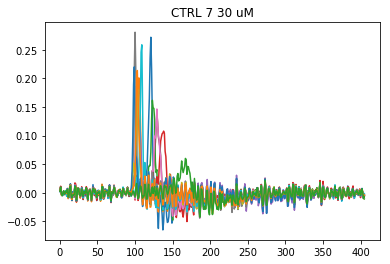

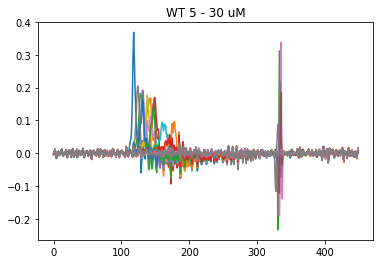

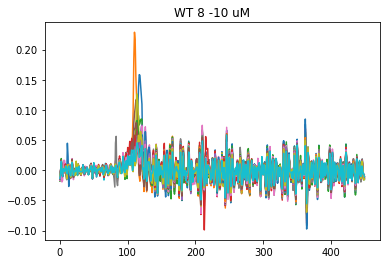

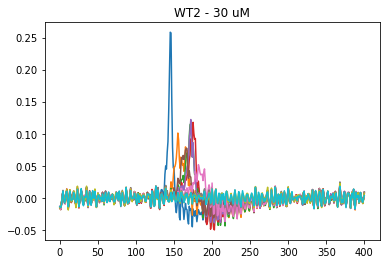

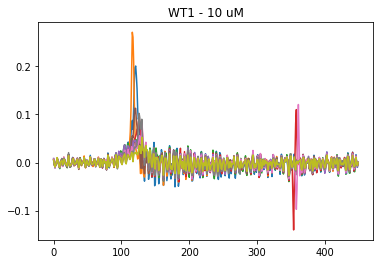

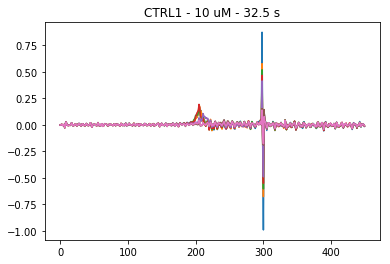

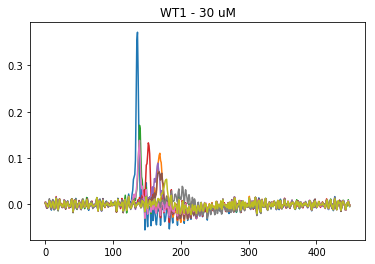

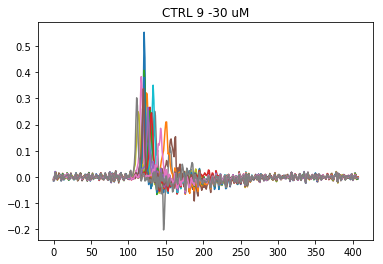

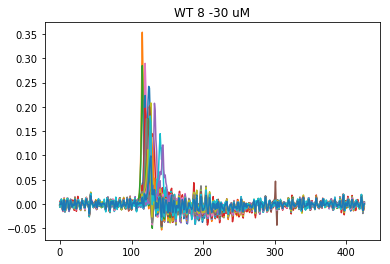

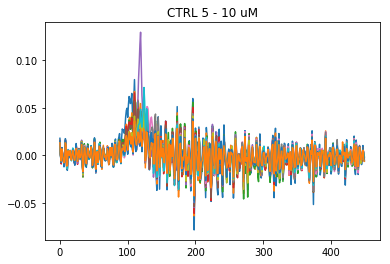

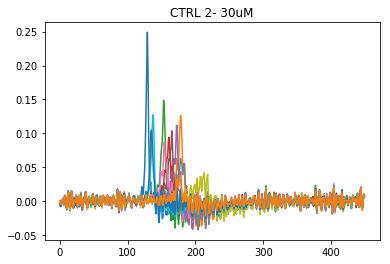

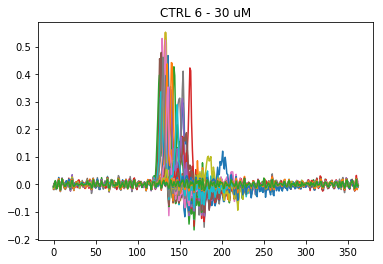

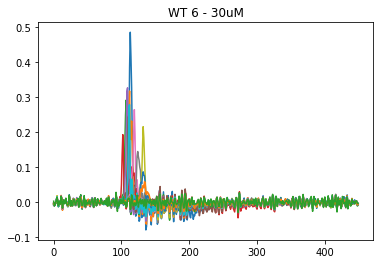

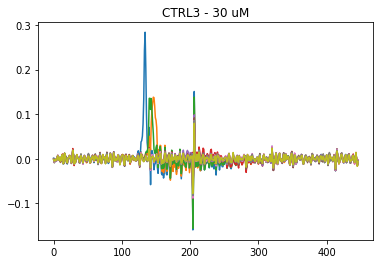

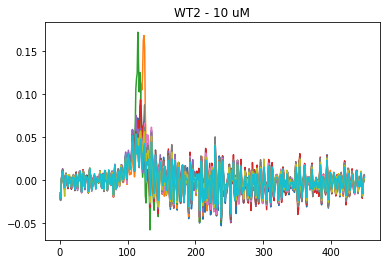

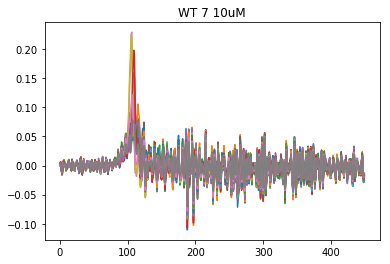

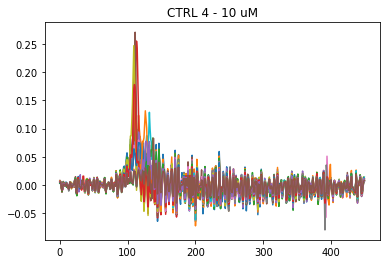

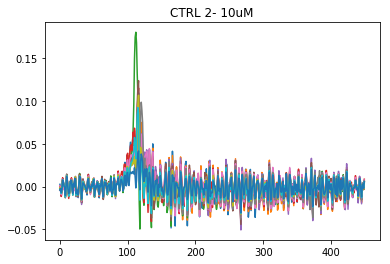

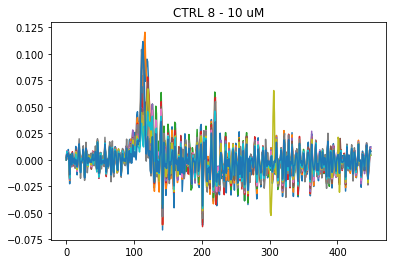

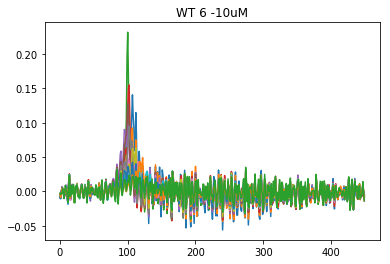

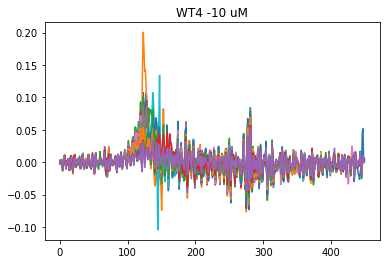

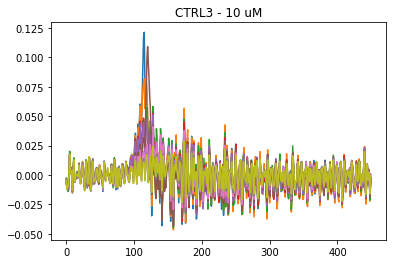

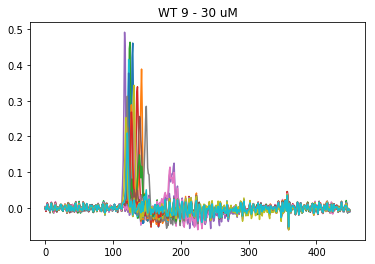

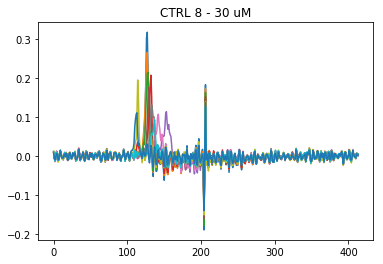

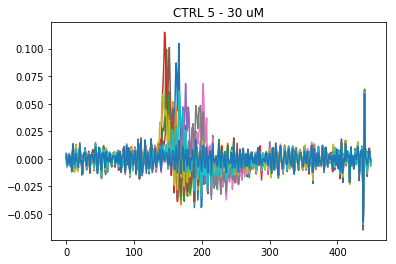

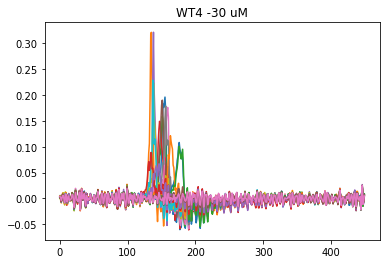

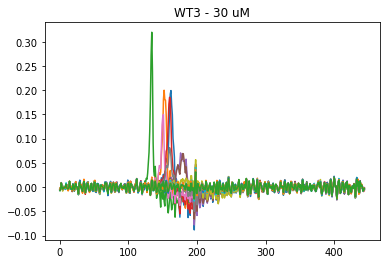

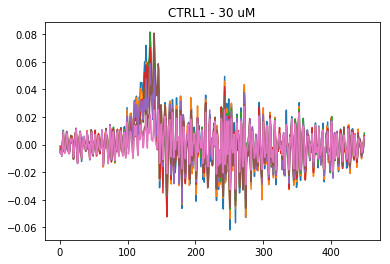

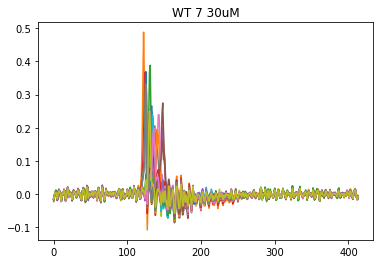

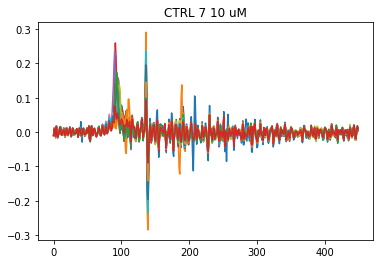

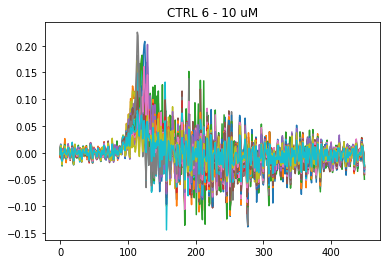

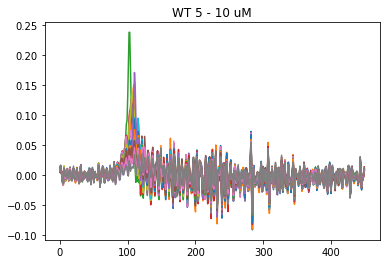

In [21]:
wb.plot_derivatives()